In [20]:
!pip install pandas numpy matplotlib seaborn scipy scikit-learn statsmodels

In [21]:
# Unit 1.0: Imports and Data Load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statsmodels.stats.weightstats import ttest_ind
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

df = pd.read_csv('Datasets/Set 20 - Diamond prices dataset.csv')

In [22]:
# Unit 1.1: Dataset Overview and Feature Identification
print("Column names and dtypes:\n")
print(df.dtypes)
print("\nShape (rows, columns):", df.shape)
print("\nFirst 5 rows:\n")
display(df.head())
print("\nLast 5 rows:\n")
display(df.tail())

# If an index-like column exists (named 'index' or similar), remove it.
index_like_cols = [c for c in df.columns if c.lower() in ('index','unnamed: 0')]
if index_like_cols:
    print("\nDropping index-like columns:", index_like_cols)
    df.drop(columns=index_like_cols, inplace=True)
    print("New shape:", df.shape)

Column names and dtypes:

index      float64
carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price      float64
x          float64
y          float64
z          float64
dtype: object

Shape (rows, columns): (54943, 11)

First 5 rows:



,index,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.0,0.23,Ideal,E,SI2,61.5,55.0,326.0,NaN,3.98,2.43
1,2.0,0.21,Premium,E,SI1,59.8,61.0,326.0,3.89,3.84,2.31
2,3.0,0.23,NaN,E,NaN,56.9,65.0,327.0,4.05,4.07,2.31
3,4.0,0.29,Premium,I,VS2,62.4,58.0,334.0,4.20,4.23,2.63
4,NaN,0.31,Good,J,SI2,63.3,58.0,335.0,4.34,4.35,2.75



Last 5 rows:



,index,carat,cut,color,clarity,depth,table,price,x,y,z
54938,996.0,0.54,Ideal,D,VVS2,61.4,52.0,2897.0,5.30,5.34,3.26
54939,997.0,0.72,Ideal,E,SI1,62.5,55.0,2897.0,5.69,5.74,3.57
54940,998.0,NaN,Good,F,VS1,59.4,61.0,2897.0,5.82,5.89,3.48
54941,999.0,0.74,Premium,NaN,VS2,61.8,58.0,2897.0,5.81,5.77,3.58
54942,1000.0,1.12,Premium,J,SI2,60.6,59.0,2898.0,6.68,6.61,4.03



Dropping index-like columns: ['index']
New shape: (54943, 10)


In [23]:
# Unit 1.2: Data Quality Insights - missing, null, duplicates, anomalous dimensions
print("Missing values per column:\n")
print(df.isnull().sum())

print("\nNumber of duplicate rows:", df.duplicated().sum())

# Identify zero or negative values for x,y,z and illogical depth/table
zero_or_negative = {}
for col in ['x','y','z','depth','table','price','carat']:
    if col in df.columns:
        zero_or_negative[col] = ((df[col] <= 0).sum())
print("\nCounts of zero/negative values per key numeric column:\n", zero_or_negative)

# Describe how to handle: implement actual cleaning: drop rows with missing critical numeric values, drop duplicates, remove rows with non-positive x,y,z,carat,price
initial_shape = df.shape
df_clean = df.copy()
df_clean.drop_duplicates(inplace=True)
df_clean = df_clean[~(df_clean[['x','y','z','carat','price']].le(0).any(axis=1))]
df_clean = df_clean.dropna(subset=['price','carat','x','y','z'])
print("\nShape before cleaning:", initial_shape, "after cleaning:", df_clean.shape)

Missing values per column:

carat      2747
cut        2747
color      2747
clarity    2747
depth      2756
table      2747
price      2747
x          2763
y          2758
z          2758
dtype: int64

Number of duplicate rows: 403

Counts of zero/negative values per key numeric column:
 {'x': np.int64(8), 'y': np.int64(7), 'z': np.int64(20), 'depth': np.int64(0), 'table': np.int64(0), 'price': np.int64(0), 'carat': np.int64(0)}

Shape before cleaning: (54943, 10) after cleaning: (42093, 10)


In [24]:
# Unit 1.3: Descriptive Statistical Summary for numerical columns
num_cols = ['price','carat','depth','table','x','y','z']
num_cols = [c for c in num_cols if c in df_clean.columns]

desc = df_clean[num_cols].agg(['mean','median','std','min','max']).T
desc['range'] = desc['max'] - desc['min']
desc = desc.rename(columns={'median':'50%'})
display(desc)

# Determine skewness and decide whether mean or median better represents each variable
skews = df_clean[num_cols].skew().to_frame(name='skewness')
skews['recommended_measure'] = np.where(skews['skewness'].abs() > 0.5, 'median', 'mean')
display(skews)
print("\nPrice distribution skewness:", skews.loc['price','skewness'])

,mean,50%,std,min,max,range
price,3903.756468,2415.00,3963.815897,326.00,18818.00,18492.00
carat,0.794977,0.70,0.470742,0.20,5.01,4.81
depth,61.748616,61.80,1.428344,43.00,79.00,36.00
table,57.459885,57.00,2.239902,43.00,95.00,52.00
x,5.727003,5.70,1.113080,3.73,10.74,7.01
y,5.730566,5.71,1.141968,3.68,58.90,55.22
z,3.536644,3.52,0.688327,1.07,8.06,6.99


,skewness,recommended_measure
price,1.637965,median
carat,1.134316,median
depth,-0.101609,mean
table,0.837782,median
x,0.401650,mean
y,3.035260,median
z,0.404190,mean



Price distribution skewness: 1.6379650563158688


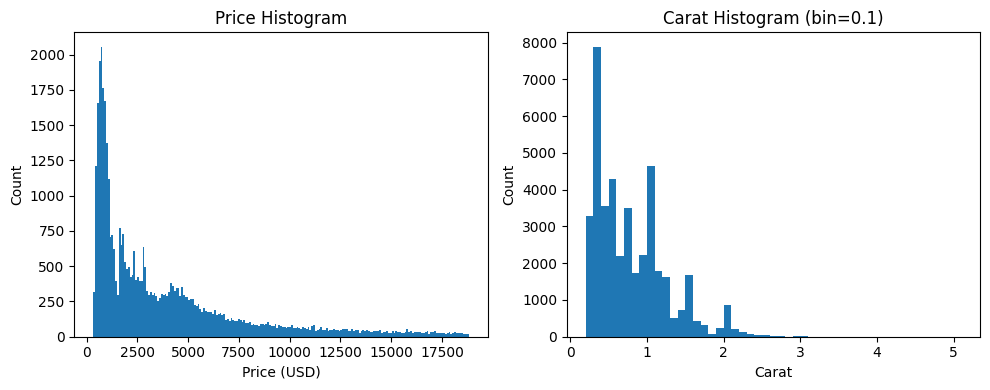

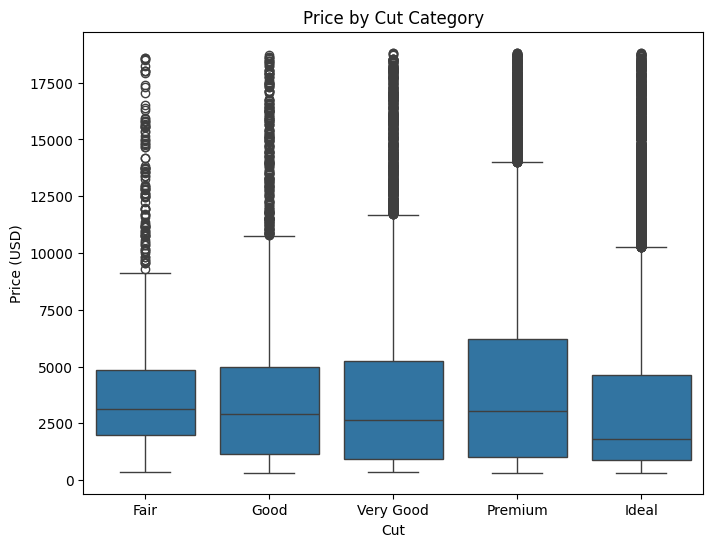

In [25]:
# Unit 1.4: Visual Data Exploration - Histograms and Boxplot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
bins_price = int(np.sqrt(len(df_clean)))
plt.hist(df_clean['price'], bins=bins_price)
plt.title('Price Histogram')
plt.xlabel('Price (USD)')
plt.ylabel('Count')

plt.subplot(1,2,2)
bin_edges = np.arange(df_clean['carat'].min(), df_clean['carat'].max()+0.1, 0.1)
plt.hist(df_clean['carat'], bins=bin_edges)
plt.title('Carat Histogram (bin=0.1)')
plt.xlabel('Carat')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
sns.boxplot(x='cut', y='price', data=df_clean, order=['Fair','Good','Very Good','Premium','Ideal'])
plt.title('Price by Cut Category')
plt.xlabel('Cut')
plt.ylabel('Price (USD)')
plt.show()

Outlier counts and bounds:
price {'lower': np.float64(-5503.0), 'upper': np.float64(11713.0), 'count_outliers': np.int64(2834)}
carat {'lower': np.float64(-0.5599999999999999), 'upper': np.float64(2.0), 'count_outliers': np.int64(1428)}
depth {'lower': np.float64(58.75), 'upper': np.float64(64.75), 'count_outliers': np.int64(1865)}
table {'lower': np.float64(51.5), 'upper': np.float64(63.5), 'count_outliers': np.int64(445)}


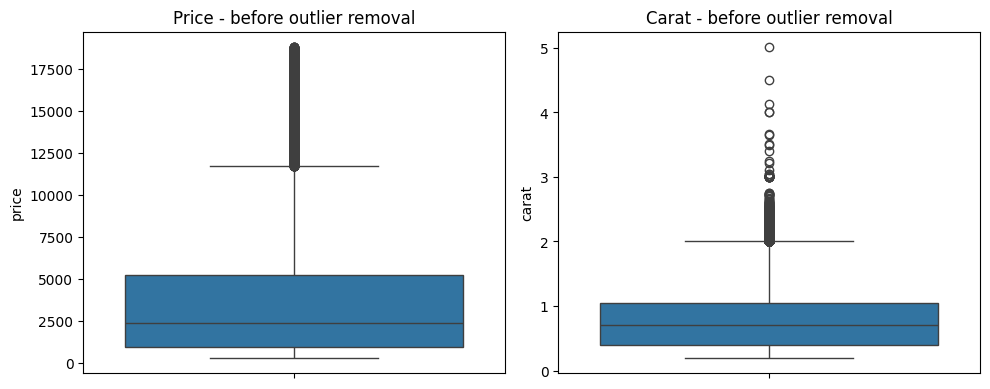


Shape before outlier removal: (42093, 10) after: (33138, 10)


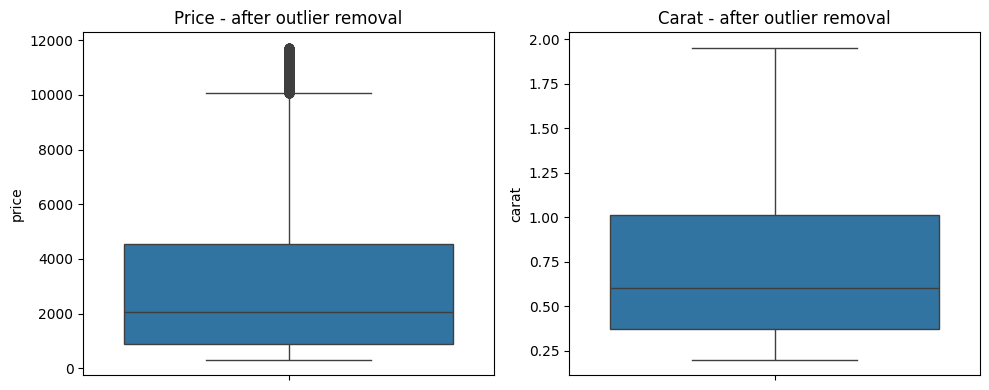

In [26]:
# Unit 1.5: Outlier Detection and Treatment using IQR
def iqr_bounds(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return lower, upper

cols_to_check = ['price','carat','depth','table']
outlier_info = {}
for c in cols_to_check:
    if c in df_clean.columns:
        low, high = iqr_bounds(df_clean[c])
        mask = (df_clean[c] < low) | (df_clean[c] > high)
        outlier_info[c] = {'lower': low, 'upper': high, 'count_outliers': mask.sum()}

print("Outlier counts and bounds:")
for k,v in outlier_info.items():
    print(k, v)

# Visualize before removal for price and carat
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.boxplot(y=df_clean['price'])
plt.title('Price - before outlier removal')
plt.subplot(1,2,2)
sns.boxplot(y=df_clean['carat'])
plt.title('Carat - before outlier removal')
plt.tight_layout()
plt.show()

# Remove outliers based on IQR across the selected columns (conservative: remove if outlier in any of these)
df_no_out = df_clean.copy()
for c in cols_to_check:
    if c in df_no_out.columns:
        low, high = iqr_bounds(df_no_out[c])
        df_no_out = df_no_out[(df_no_out[c] >= low) & (df_no_out[c] <= high)]

print("\nShape before outlier removal:", df_clean.shape, "after:", df_no_out.shape)

# Visualize after removal for same vars
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.boxplot(y=df_no_out['price'])
plt.title('Price - after outlier removal')
plt.subplot(1,2,2)
sns.boxplot(y=df_no_out['carat'])
plt.title('Carat - after outlier removal')
plt.tight_layout()
plt.show()

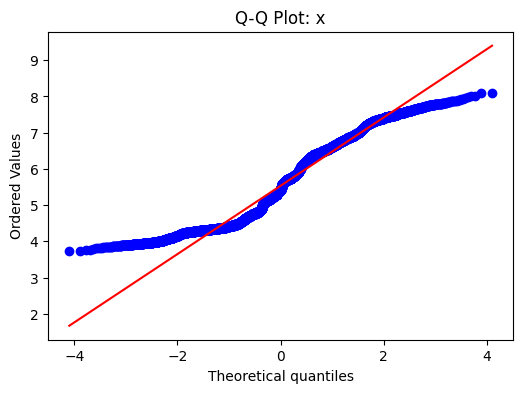

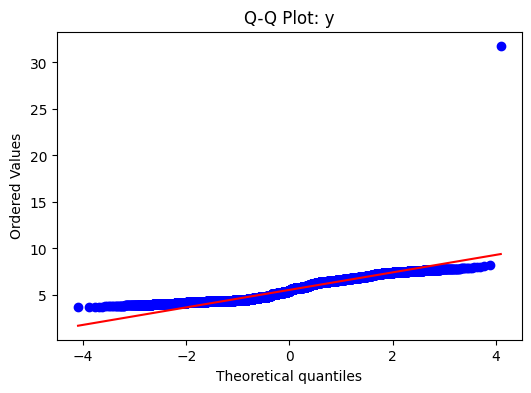

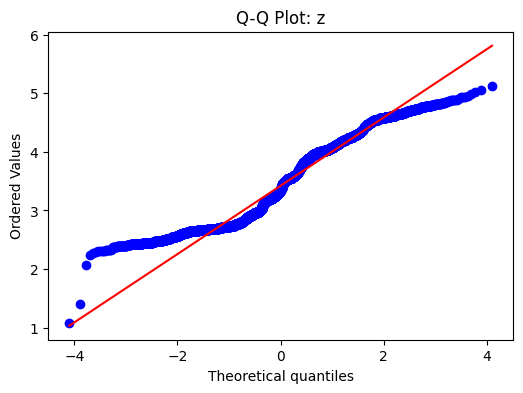

In [27]:
# Unit 1.6: Normality Check using Q-Q Plot for x, y, z
for c in ['x','y','z']:
    if c in df_no_out.columns:
        plt.figure(figsize=(6,4))
        stats.probplot(df_no_out[c], dist="norm", plot=plt)
        plt.title(f'Q-Q Plot: {c}')
        plt.show()

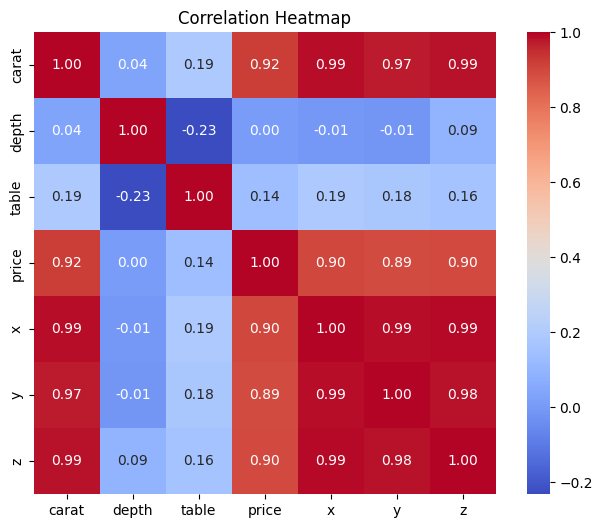

Variable with strongest absolute correlation with price: carat 0.9225307512511604
Variable with weakest absolute correlation with price: depth 0.004747635073867625


In [28]:
# Unit 1.7: Correlation Mapping - heatmap and strongest/weakest correlation with price
numeric = df_no_out.select_dtypes(include=[np.number])
corr = numeric.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

if 'price' in corr.columns:
    corrs_with_price = corr['price'].drop('price').abs().sort_values(ascending=False)
    strongest = corrs_with_price.index[0]
    weakest = corrs_with_price.index[-1]
    print("Variable with strongest absolute correlation with price:", strongest, corr.loc[strongest,'price'])
    print("Variable with weakest absolute correlation with price:", weakest, corr.loc[weakest,'price'])

In [29]:
# Unit 2.1: 95% Confidence Interval for Mean Carat (t-distribution)
carat_arr = df_no_out['carat'].values
n = len(carat_arr)
mean_carat = carat_arr.mean()
std_carat = carat_arr.std(ddof=1)
se = std_carat / np.sqrt(n)
alpha = 0.05
t_crit = stats.t.ppf(1 - alpha/2, df=n-1)
ci_lower = mean_carat - t_crit * se
ci_upper = mean_carat + t_crit * se
print(f"n={n}, mean_carat={mean_carat:.6f}, std={std_carat:.6f}")
print(f"95% CI for mean carat: ({ci_lower:.6f}, {ci_upper:.6f})")

n=33138, mean_carat=0.703181, std=0.364919
95% CI for mean carat: (0.699252, 0.707110)


In [30]:
# Unit 2.2: Margin of Error for Mean Price at 90%, 95%, 99% confidence levels
price_arr = df_no_out['price'].values
n_price = len(price_arr)
mean_price = price_arr.mean()
std_price = price_arr.std(ddof=1)
results = []
for conf in [0.90, 0.95, 0.99]:
    alpha = 1 - conf
    z = stats.t.ppf(1 - alpha/2, df=n_price-1)
    se_price = std_price / np.sqrt(n_price)
    me = z * se_price
    results.append((conf, me))
for conf, me in results:
    print(f"{int(conf*100)}% confidence level -> Margin of Error = {me:.2f}")

90% confidence level -> Margin of Error = 24.37
95% confidence level -> Margin of Error = 29.03
99% confidence level -> Margin of Error = 38.16


In [31]:
# Unit 3.1: Hypothesis Test - difference in mean price between 'Ideal' and 'Fair' cut diamonds
group_ideal = df_no_out[df_no_out['cut']=='Ideal']['price']
group_fair = df_no_out[df_no_out['cut']=='Fair']['price']

# Welch's t-test (independent, unequal variances)
t_stat, p_value, dfree = ttest_ind(group_ideal, group_fair, usevar='unequal')
print("Ideal group n:", len(group_ideal), "Fair group n:", len(group_fair))
print(f"t-statistic = {t_stat:.6f}, p-value = {p_value:.6f}")

alpha = 0.05
if p_value < alpha:
    print("Reject H0: significant difference in average price between Ideal and Fair cuts (alpha=0.05).")
else:
    print("Fail to reject H0: no significant difference detected (alpha=0.05).")

Ideal group n: 13548 Fair group n: 176
t-statistic = -3.700661, p-value = 0.000285
Reject H0: significant difference in average price between Ideal and Fair cuts (alpha=0.05).


Pearson correlation coefficient between carat and price: r = 0.922531, p-value = 0.000000


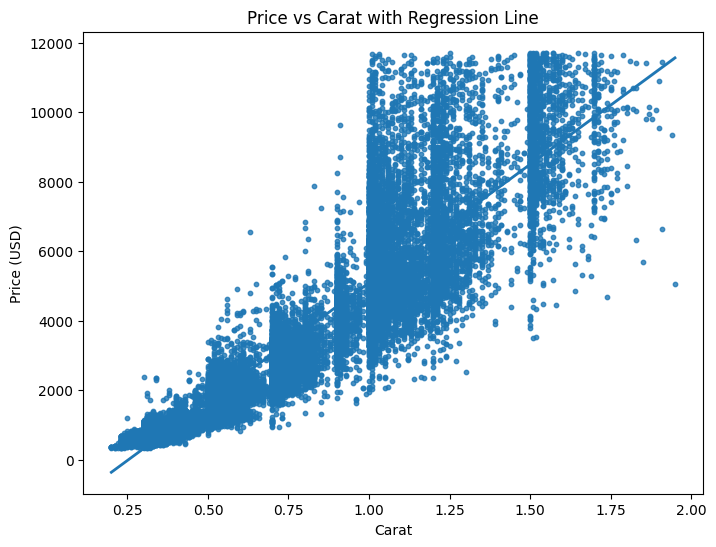

In [32]:
# Unit 3.2: Relationship between Carat and Price - Pearson correlation and scatter with regression line
pearson_r, pearson_p = stats.pearsonr(df_no_out['carat'], df_no_out['price'])
print(f"Pearson correlation coefficient between carat and price: r = {pearson_r:.6f}, p-value = {pearson_p:.6f}")

plt.figure(figsize=(8,6))
sns.regplot(x='carat', y='price', data=df_no_out, scatter_kws={'s':10}, line_kws={'linewidth':2})
plt.title('Price vs Carat with Regression Line')
plt.xlabel('Carat')
plt.ylabel('Price (USD)')
plt.show()

In [33]:
# Unit 3.3: Simple Linear Regression Model: Price ~ Carat
X = df_no_out[['carat']].values
y = df_no_out['price'].values
model = LinearRegression()
model.fit(X, y)
beta0 = model.intercept_
beta1 = model.coef_[0]
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

print(f"Regression equation: Price = {beta0:.2f} + {beta1:.2f} * Carat")
print(f"Interpretation: On average, each additional carat increases price by ${beta1:.2f}")
print(f"R^2 = {r2:.4f}")

# Optional: show first 5 actual vs predicted
comparison = pd.DataFrame({'carat': df_no_out['carat'].iloc[:5].values,
                           'actual_price': y[:5],
                           'predicted_price': y_pred[:5]})
display(comparison)

Regression equation: Price = -1730.05 + 6817.17 * Carat
Interpretation: On average, each additional carat increases price by $6817.17
R^2 = 0.8511


,carat,actual_price,predicted_price
0,0.21,326.0,-298.441047
1,0.29,334.0,246.932615
2,0.31,335.0,383.276030
3,0.23,338.0,-162.097631
4,0.30,339.0,315.104322
